## Imports

In [1]:
import multiprocessing as mp

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler

from Bio.SeqIO import parse
from seqlike import aaSeqLike
from seqlike.alphabets import AA
from tqdm.auto import tqdm

from therapeutic_enzyme_engineering_with_generative_neural_networks.models import VAE
from therapeutic_enzyme_engineering_with_generative_neural_networks.SeqLikeDataset import (
    SeqLikeDataset
)

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'

import seaborn as sns; sns.set_style("ticks")
%config InlineBackend.figure_formats = ['svg']
mpl.rcParams['image.interpolation'] = 'nearest'


Loading BokehJS ...

## Dataset

In [9]:
# the following file will exist if you've run the included get_homologous_seqs and remove_gappy_seqs notebooks.
input_file = "../data/tr-B5LY47-B5LY47-ECOLX_blast_nr_5000_aligned.fasta"
seqs = pd.Series([aaSeqLike(s, alphabet=AA) for s in parse(input_file, "fasta")])
seqs = pd.Series([x for x in seqs if "B" not in x and "X" not in x])

dataset = SeqLikeDataset(seqs)

train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(
    train_dataset, shuffle=True, batch_size=128, num_workers=mp.cpu_count(), drop_last=True, pin_memory=True
)
test_loader = DataLoader(
    test_dataset, shuffle=True, batch_size=128, num_workers=mp.cpu_count(), drop_last=True, pin_memory=True
)


In [10]:
seqs.sample(10).seq.plot()

Column(id='1087', ...)

## Model and optimizer creation

In [11]:
model = VAE(sequence_length=seqs.apply(len).max(), layer_sizes=[128, 96, 64], z_size=64).to(device)
model.losses = []

vae_encoder_optimizer = torch.optim.Adam(model.encoder.parameters(), amsgrad=True)
vae_decoder_optimizer = torch.optim.Adam(model.decoder.parameters(), amsgrad=True)

batch, _ = next(iter(train_loader))

model = model.to(device)


## Training loop

In [12]:
n_training_batches = len(train_loader)
n_testing_batches = len(test_loader)
n_epochs = 30  # this likely isn't enough for convergence, but does demonstrate training.  Convergence specifics will vary with sequence family & MSA.


In [13]:
batches = 0
for epoch in tqdm(range(n_epochs)):
    model.train()

    for i, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)

        vae_encoder_optimizer.zero_grad()
        vae_decoder_optimizer.zero_grad()

        recon, mu, logvar, z_sample = model(data)

        # recon loss
        recon_loss = -(data * torch.log(recon) + (1 - data) * torch.log(1 - recon)).squeeze().mean(dim=1).mean(dim=1)

        # KL loss = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        kl_element = 1 + logvar - mu ** 2 - logvar.exp()
        kl_loss = -0.5 * kl_element.mean(dim=1) * (batches + 1) / float(n_epochs * n_training_batches)

        total_loss = torch.mean(recon_loss + kl_loss)

        model.losses.append(
            {
                "batch_id": batches,
                "train_kl": kl_loss.data.mean(),
                "train_recon": recon_loss.data.mean(),
                "train_total": total_loss.item(),
            }
        )

        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 2)
        vae_encoder_optimizer.step()
        vae_decoder_optimizer.step()


        batches += 1

    model.eval()
    test_data, test_target = next(iter(test_loader))
    test_data = test_data.to(device)
    test_target = test_target.to(device)

    test_out, mu, logvar, z_sample = model(test_data)

    # recon loss
    recon_loss = -(data * torch.log(recon) + (1 - data) * torch.log(1 - recon)).squeeze().mean(dim=1).mean(dim=1)

    # KL loss = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    kl_element = 1 + logvar - mu ** 2 - logvar.exp()
    kl_loss = -0.5 * kl_element.mean(dim=1) * (batches + 1) / float(n_epochs * n_training_batches)

    total_loss = torch.mean(recon_loss + kl_loss)

    model.losses.append(
        {
            "batch_id": batches,
            "test_total": total_loss.item(),
            "test_kl": kl_loss.mean().item(),
            "test_recon": recon_loss.mean().item(),
        }
    )


  0%|          | 0/30 [00:00<?, ?it/s]

## Plot training and test losses

<AxesSubplot:title={'center':'Training and Test losses over time'}, xlabel='Batch', ylabel='Loss value'>

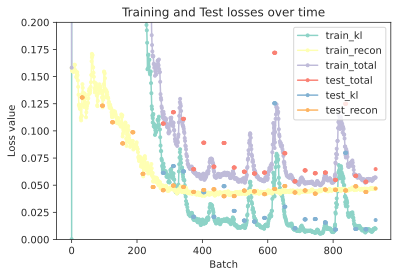

In [24]:
losses = pd.DataFrame(model.losses).set_index("batch_id")
losses.rolling(5, min_periods=1).mean().plot(
    ylim=(0, 0.2), marker=".", title="Training and Test losses over time", ylabel="Loss value", xlabel="Batch"
)


## Sample reconstructions

In [15]:
# We will pick the first sequence as an example
ecoli_beta_lactamase = SeqLikeDataset(seqs.iloc[0:1])
ecoli_tensor, _ = ecoli_beta_lactamase[0]
ecoli_tensor = ecoli_tensor.unsqueeze(0).to(device)

# put the output in a dictionary, do data type conversions here for convenience. 
output = dict(zip(['recon', 'mu', 'logvar', 'z_sample'], model(ecoli_tensor)))
for k, v in output.items():
    output[k] = v.cpu().squeeze().detach().numpy()

Text(0.5, 1.0, 'Original E. Coli sequence in one-hot format')

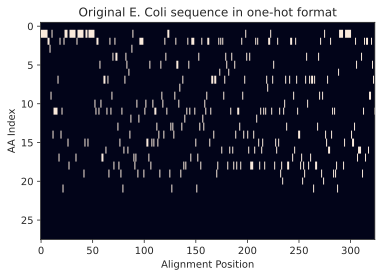

In [21]:
plt.imshow(ecoli_tensor.cpu().squeeze().T, vmax=1, vmin=0)
plt.axis("tight")
plt.ylabel("AA Index")
plt.xlabel("Alignment Position")
plt.title("Original E. Coli sequence in one-hot format")


Text(0.5, 1.0, 'p(AA) of reconstructed e. coli sequence in one-hot format')

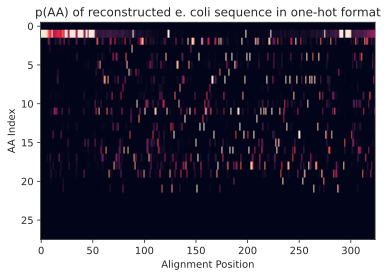

In [17]:
plt.imshow(output['recon'].T, vmax=1, vmin=0)
plt.axis('tight')
plt.ylabel("AA Index")
plt.xlabel("Alignment Position")
plt.title("p(AA) of reconstructed e. coli sequence in one-hot format")


In [25]:
# convert example reconstructed sequence to a SeqLike
aaSeqLike(output['recon'], alphabet=AA)[50:]

NT: None 

*** AA: SeqRecord(seq=Seq('--QLAALERSSGGRLGVAAIDTADNSQILHRADERFPMC-STFKVMAAAAVLKQ...---'), id='d2a44ef9-c24d-418c-82f8-2a3672412dc1', name='<unknown name>', description='<unknown description>', dbxrefs=[])